In [0]:
!pip install kaggle

In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Mar 15 06:19 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c bengaliai-cv19

 99% 980M/986M [00:06<00:00, 187MB/s]
100% 986M/986M [00:06<00:00, 166MB/s]
100% 988M/992M [00:05<00:00, 190MB/s]
100% 992M/992M [00:06<00:00, 164MB/s]
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 182MB/s]
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 896kB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 4.98MB/s]
 98% 970M/991M [00:24<00:00, 191MB/s]
100% 991M/991M [00:24<00:00, 42.0MB/s]
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 181MB/s]
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 188MB/s]
  0% 0.00/16.8k [00:00<?, ?B/s]
100% 16.8k/16.8k [00:00<00:00, 16.3MB/s]
  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 1.88MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 187MB/s]
  0% 0.00/4.75k [00:00<?, ?B/s]
100% 4.75k/4.75k [00:00<00:00, 5.01MB/s]
 98% 978M/993M [00:27<00:00, 98.1MB/s]
100% 993M/993M [00:27<00:00, 37.9MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/content/train_image_data_0.parquet.zip
/content/kaggle.json
/content/test.csv
/content/sample_submission.csv
/content/train.csv.zip
/content/train_multi_diacritics.csv
/content/test_image_data_3.parquet.zip
/content/class_map_corrected.csv
/content/train_image_data_1.parquet.zip
/content/test_image_data_0.parquet.zip
/content/class_map.csv
/content/train_image_data_2.parquet.zip
/content/test_image_data_1.parquet.zip
/content/test_image_data_2.parquet.zip
/content/train_image_data_3.parquet.zip
/content/.config/.last_opt_in_prompt.yaml
/content/.config/active_config
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/gce
/content/.config/.last_update_check.json
/content/.config/.metricsUUID
/content/.config/configurations/config_default
/content/.config/logs/2020.03.03/18.10.27.459924.log
/content/.config/logs/2020.03.03/18.10.08.298109.log
/content/.config/logs/2020.03.03/18.10.58.695293.log
/content/.config/logs/2020.03.03/18.10.40.045715.log


In [0]:
!unzip train.csv

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
for i in range(4):
  !unzip train_image_data_{i}.parquet.zip

Archive:  train_image_data_0.parquet.zip
  inflating: train_image_data_0.parquet  
Archive:  train_image_data_1.parquet.zip
  inflating: train_image_data_1.parquet  
Archive:  train_image_data_2.parquet.zip
  inflating: train_image_data_2.parquet  
Archive:  train_image_data_3.parquet.zip
  inflating: train_image_data_3.parquet  


In [0]:
for i in range(4):
  !unzip test_image_data_{i}.parquet.zip

Archive:  test_image_data_0.parquet.zip
  inflating: test_image_data_0.parquet  
Archive:  test_image_data_1.parquet.zip
  inflating: test_image_data_1.parquet  
Archive:  test_image_data_2.parquet.zip
  inflating: test_image_data_2.parquet  
Archive:  test_image_data_3.parquet.zip
  inflating: test_image_data_3.parquet  


In [0]:
train_df_ = pd.read_csv('train.csv')
test_df_ = pd.read_csv('test.csv')
class_map_df = pd.read_csv('class_map.csv')
sample_sub_df = pd.read_csv('sample_submission.csv')

In [0]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')
IMG_SIZE=64
N_CHANNELS=1

In [0]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [0]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [0]:
#Original Model
import keras.backend as K
K.clear_session()
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model) #1024
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model) #512

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [0]:
#Smaller Model

#Original Model
import keras.backend as K
K.clear_session()
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)


model = Flatten()(model)
model = Dense(512, activation = "relu")(model) #1024
model = Dropout(rate=0.3)(model)
dense = Dense(256, activation = "relu")(model) #512

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [0]:
from keras.utils import plot_model
plot_model(model, to_file = 'model.png')

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
batch_size = 128
epochs = 30

In [0]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [0]:
HEIGHT = 137
WIDTH = 236

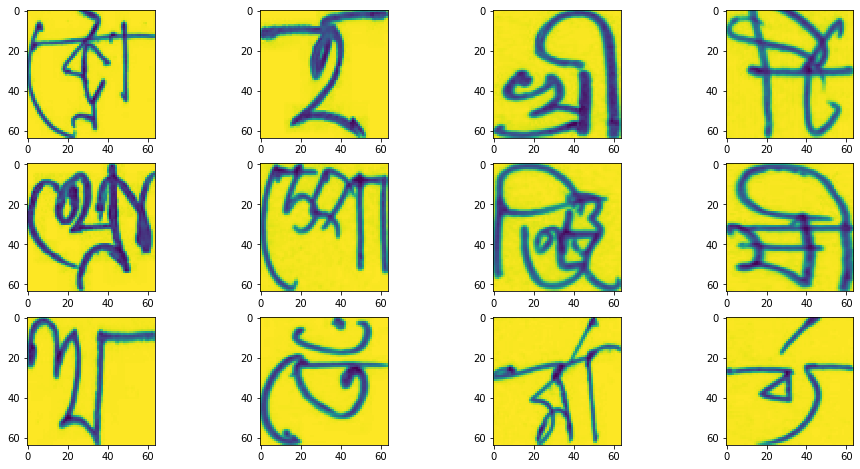

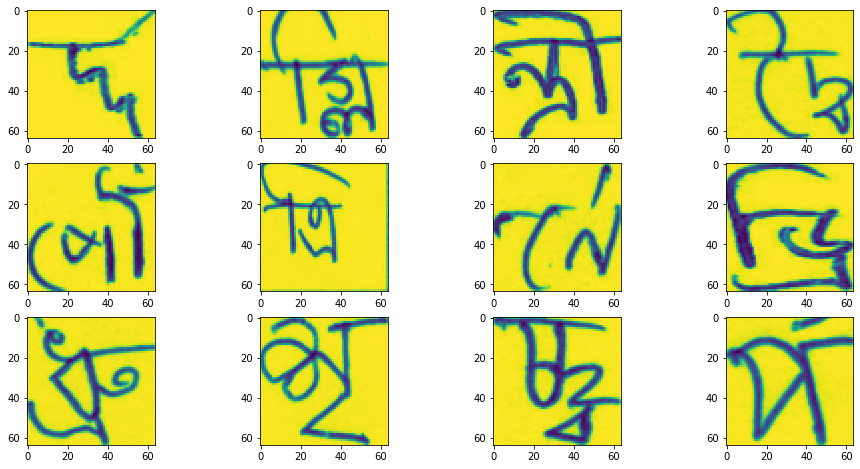

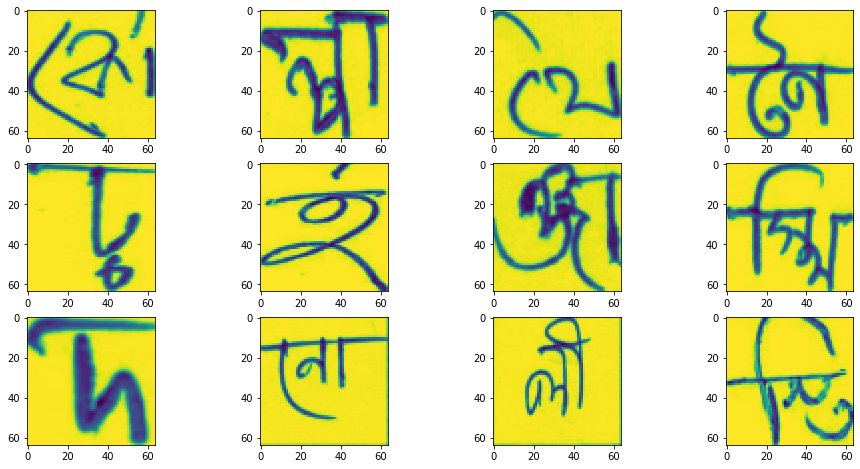

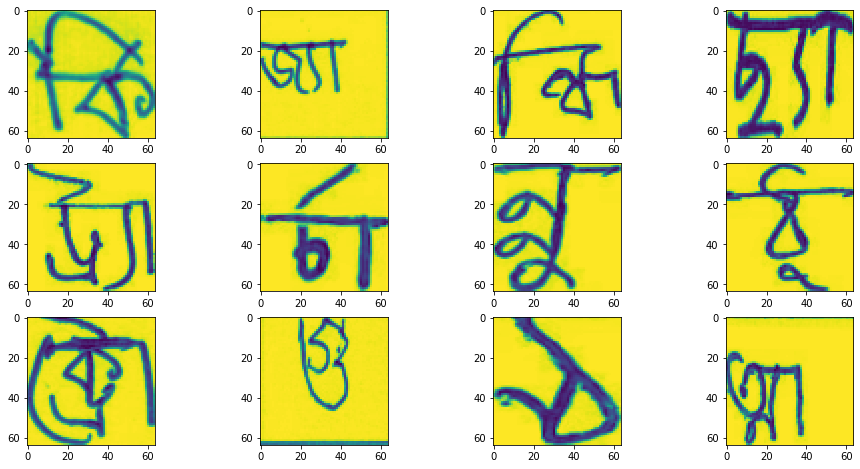

In [0]:
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:

      for col in row:
        col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
        count += 1
    plt.show()

In [0]:
gc.collect()
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    '''
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
     for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    #plt.show()
    '''
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant= train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.1, random_state=123457)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        shear_range = 0.15,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

     # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant},
                                               batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
353/353 [==============================] - 60s 169ms/step - loss: 0.8195 - dense_3_loss: 0.4670 - dense_4_loss: 0.2062 - dense_5_loss: 0.1463 - dense_3_acc: 0.8709 - dense_4_acc: 0.9396 - dense_5_acc: 0.9549 - val_loss: 0.4005 - val_dense_3_loss: 0.2537 - val_dense_4_loss: 0.0719 - val_dense_5_loss: 0.0748 - val_dense_3_acc: 0.9287 - val_dense_4_acc: 0.9815 - val_dense_5_acc: 0.9795
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `dense_3_accuracy` which is not available. Available metrics are: val_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_3_acc,val_dense_4_acc,val_dense_5_acc,loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_3_acc,dense_4_acc,dense_5_acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `dense_4_accuracy` which is not available. Available metrics are: val_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_3_acc,val_dense_4_acc,val_dense_5_acc,loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_3_acc,dense_4_acc,dense_5_acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on 

353/353 [==============================] - 58s 164ms/step - loss: 0.7336 - dense_3_loss: 0.4100 - dense_4_loss: 0.1925 - dense_5_loss: 0.1311 - dense_3_acc: 0.8825 - dense_4_acc: 0.9428 - dense_5_acc: 0.9589 - val_loss: 0.4039 - val_dense_3_loss: 0.2630 - val_dense_4_loss: 0.0714 - val_dense_5_loss: 0.0696 - val_dense_3_acc: 0.9263 - val_dense_4_acc: 0.9823 - val_dense_5_acc: 0.9799
Epoch 3/30
 20/353 [>.............................] - ETA: 50s - loss: 0.8167 - dense_3_loss: 0.4943 - dense_4_loss: 0.1856 - dense_5_loss: 0.1367 - dense_3_acc: 0.8695 - dense_4_acc: 0.9480 - dense_5_acc: 0.9563

KeyboardInterrupt: ignored

In [0]:
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_acc'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_acc'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_acc'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_acc'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_acc'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_acc'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

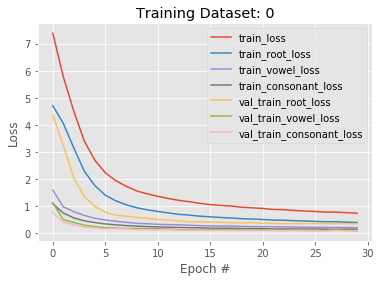

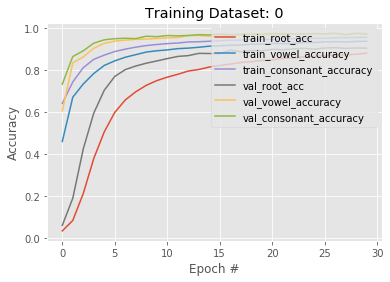

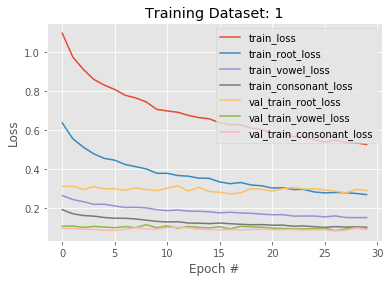

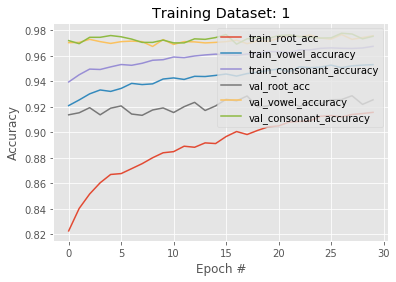

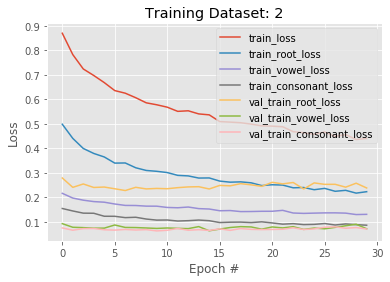

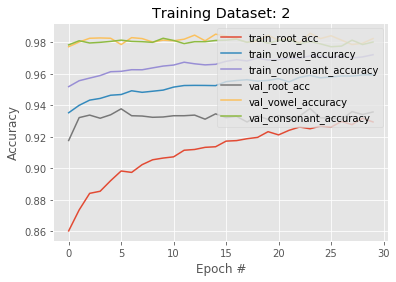

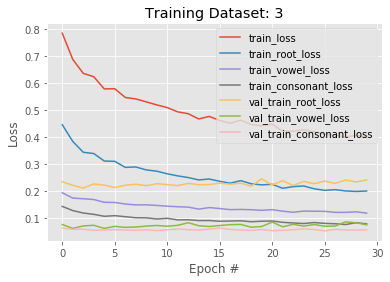

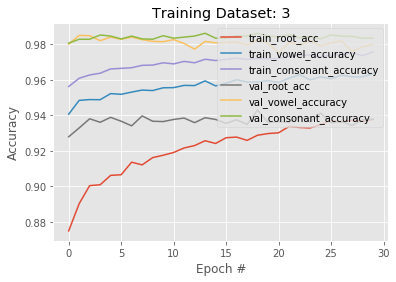

In [0]:
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [0]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks_max_acc = myCallback()


tensorboard_callback = keras.callbacks.TensorBoard("logs")

In [0]:
import keras.backend as K
from keras.layers.advanced_activations import LeakyReLU
#K.clear_session()
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = BatchNormalization(momentum=0.15)(model1)
model1 = MaxPool2D(pool_size=(2, 2))(model1)
model1 = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model1)
model1 = Dropout(rate=0.4)(model1)

model1 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = BatchNormalization(momentum=0.15)(model1)
model1 = MaxPool2D(pool_size=(2, 2))(model1)
model1 = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model1)
model1 = BatchNormalization(momentum=0.15)(model1)
model1 = Dropout(rate=0.4)(model1)

model1 = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = BatchNormalization(momentum=0.15)(model1)
model1 = MaxPool2D(pool_size=(2, 2))(model1)
model1 = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model1)
model1 = BatchNormalization(momentum=0.15)(model1)
model1 = Dropout(rate=0.4)(model1)

model1 = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)
model1 = BatchNormalization(momentum=0.15)(model1)
model1 = MaxPool2D(pool_size=(2, 2))(model1)
model1 = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model1)
model1 = BatchNormalization(momentum=0.15)(model1)
model1 = Dropout(rate=0.4)(model1)

model1 = Flatten()(model1)
model1 = Dense(1024, activation = "relu")(model1)
model1 = Dropout(rate=0.4)(model1)
dense1 = Dense(512, activation = "relu")(model1)

head_root = Dense(168, activation = 'softmax')(dense1)
head_vowel = Dense(11, activation = 'softmax')(dense1)
head_consonant = Dense(7, activation = 'softmax')(dense1)

model1 = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [0]:
from keras.optimizers import RMSprop
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
gc.collect()
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    '''
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
     for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    #plt.show()
    '''
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant= train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.1, random_state=123457)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        shear_range = 0.15,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

     # Fit the model
    history = model1.fit_generator(datagen.flow(x_train, {'dense_8': y_train_root, 'dense_9': y_train_vowel, 'dense_10': y_train_consonant},
                                               batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
176/176 [==============================] - 33s 186ms/step - loss: 7.8750 - dense_8_loss: 4.7820 - dense_9_loss: 1.8823 - dense_10_loss: 1.2107 - dense_8_acc: 0.0271 - dense_9_acc: 0.3369 - dense_10_acc: 0.6167 - val_loss: 6.9322 - val_dense_8_loss: 4.5992 - val_dense_9_loss: 1.2628 - val_dense_10_loss: 1.0701 - val_dense_8_acc: 0.0398 - val_dense_9_acc: 0.5367 - val_dense_10_acc: 0.6076
Epoch 2/30
  1/176 [..............................] - ETA: 16s - loss: 7.1809 - dense_8_loss: 4.6388 - dense_9_loss: 1.4573 - dense_10_loss: 1.0848 - dense_8_acc: 0.0301 - dense_9_acc: 0.5414 - dense_10_acc: 0.6015

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `dense_3_accuracy` which is not available. Available metrics are: val_loss,val_dense_8_loss,val_dense_9_loss,val_dense_10_loss,val_dense_8_acc,val_dense_9_acc,val_dense_10_acc,loss,dense_8_loss,dense_9_loss,dense_10_loss,dense_8_acc,dense_9_acc,dense_10_acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `dense_4_accuracy` which is not available. Available metrics are: val_loss,val_dense_8_loss,val_dense_9_loss,val_dense_10_loss,val_dense_8_acc,val_dense_9_acc,val_dense_10_acc,loss,dense_8_loss,dense_9_loss,dense_10_loss,dense_8_acc,dense_9_acc,dense_10_acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditi

176/176 [==============================] - 29s 163ms/step - loss: 6.8432 - dense_8_loss: 4.5145 - dense_9_loss: 1.2663 - dense_10_loss: 1.0625 - dense_8_acc: 0.0395 - dense_9_acc: 0.5546 - dense_10_acc: 0.6328 - val_loss: 6.3681 - val_dense_8_loss: 4.2884 - val_dense_9_loss: 1.1463 - val_dense_10_loss: 0.9335 - val_dense_8_acc: 0.0488 - val_dense_9_acc: 0.6100 - val_dense_10_acc: 0.6787
Epoch 3/30
176/176 [==============================] - 29s 163ms/step - loss: 6.1578 - dense_8_loss: 4.2316 - dense_9_loss: 1.0297 - dense_10_loss: 0.8966 - dense_8_acc: 0.0579 - dense_9_acc: 0.6548 - dense_10_acc: 0.6863 - val_loss: 5.5362 - val_dense_8_loss: 4.0187 - val_dense_9_loss: 0.8598 - val_dense_10_loss: 0.6577 - val_dense_8_acc: 0.0635 - val_dense_9_acc: 0.7096 - val_dense_10_acc: 0.7739
Epoch 4/30
176/176 [==============================] - 29s 163ms/step - loss: 5.4600 - dense_8_loss: 3.8837 - dense_9_loss: 0.8578 - dense_10_loss: 0.7185 - dense_8_acc: 0.0846 - dense_9_acc: 0.7206 - dense_10_


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
176/176 [==============================] - 30s 169ms/step - loss: 1.0554 - dense_8_loss: 0.6230 - dense_9_loss: 0.2523 - dense_10_loss: 0.1801 - dense_8_acc: 0.8315 - dense_9_acc: 0.9288 - dense_10_acc: 0.9457 - val_loss: 0.5444 - val_dense_8_loss: 0.3266 - val_dense_9_loss: 0.1137 - val_dense_10_loss: 0.1041 - val_dense_8_acc: 0.9122 - val_dense_9_acc: 0.9711 - val_dense_10_acc: 0.9703
Epoch 2/30
176/176 [==============================] - 29s 165ms/step - loss: 0.9484 - dense_8_loss: 0.5530 - dense_9_loss: 0.2335 - dense_10_loss: 0.1619 - dense_8_acc: 0.8459 - dense_9_acc: 0.9332 - dense_10_acc: 0.9501 - val_loss: 0.5468 - val_dense_8_loss: 0.3267 - val_dense_9_loss: 0.1208 - val_dense_10_loss: 0.0992 - val_dense_8_acc: 0.9102 - val_dense_9_acc: 0.9715 - val_dense_10_acc: 0.9733
Epoch 3/30
176/176 [==============================] 


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
176/176 [==============================] - 29s 167ms/step - loss: 0.7937 - dense_8_loss: 0.4548 - dense_9_loss: 0.1948 - dense_10_loss: 0.1442 - dense_8_acc: 0.8795 - dense_9_acc: 0.9448 - dense_10_acc: 0.9579 - val_loss: 0.3677 - val_dense_8_loss: 0.2392 - val_dense_9_loss: 0.0701 - val_dense_10_loss: 0.0584 - val_dense_8_acc: 0.9321 - val_dense_9_acc: 0.9841 - val_dense_10_acc: 0.9835
Epoch 2/30
176/176 [==============================] - 29s 164ms/step - loss: 0.7042 - dense_8_loss: 0.4010 - dense_9_loss: 0.1803 - dense_10_loss: 0.1230 - dense_8_acc: 0.8895 - dense_9_acc: 0.9485 - dense_10_acc: 0.9628 - val_loss: 0.3531 - val_dense_8_loss: 0.2273 - val_dense_9_loss: 0.0665 - val_dense_10_loss: 0.0593 - val_dense_8_acc: 0.9397 - val_dense_9_acc: 0.9871 - val_dense_10_acc: 0.9821
Epoch 3/30
176/176 [==============================] 


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
176/176 [==============================] - 30s 168ms/step - loss: 0.6891 - dense_8_loss: 0.3958 - dense_9_loss: 0.1737 - dense_10_loss: 0.1196 - dense_8_acc: 0.8955 - dense_9_acc: 0.9512 - dense_10_acc: 0.9644 - val_loss: 0.3445 - val_dense_8_loss: 0.2116 - val_dense_9_loss: 0.0782 - val_dense_10_loss: 0.0547 - val_dense_8_acc: 0.9436 - val_dense_9_acc: 0.9817 - val_dense_10_acc: 0.9863
Epoch 2/30
176/176 [==============================] - 29s 165ms/step - loss: 0.6113 - dense_8_loss: 0.3377 - dense_9_loss: 0.1586 - dense_10_loss: 0.1150 - dense_8_acc: 0.9058 - dense_9_acc: 0.9548 - dense_10_acc: 0.9655 - val_loss: 0.3513 - val_dense_8_loss: 0.2147 - val_dense_9_loss: 0.0790 - val_dense_10_loss: 0.0576 - val_dense_8_acc: 0.9420 - val_dense_9_acc: 0.9813 - val_dense_10_acc: 0.9821
Epoch 3/30
176/176 [==============================] 

In [0]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [0]:
for i in range(4):
    df_test_img = pd.read_parquet('test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

    results_roots = np.zeros((X_test.shape[0], 168))
    results_vowels = np.zeros((X_test.shape[0], 11))
    results_consonants = np.zeros((X_test.shape[0], 7))
    results_roots = results_roots.astype('float')
    results_vowels = results_vowels.astype('float')
    results_consonants = results_consonants.astype('float')

    for i in range(nets):
      results_roots += models[i].predict(X_test)[0]
      results_vowels += models[i].predict(X_test)[1]
      results_consonants += models[i].predict(X_test)[2]
      #preds[0] = results_roots
      #preds[1] = results_vowels
      #preds[2] = results_consonants

    results_roots = np.argmax(results_roots, axis = 1)
    results_vowels = np.argmax(results_vowels, axis = 1)
    results_consonants = np.argmax(results_consonants, axis = 1)

    preds_dict['grapheme_root'] = results_roots
    preds_dict['vowel_diacritic'] = results_vowels
    preds_dict['consonant_diacritic'] = results_consonants

    for k,id in enumerate(df_test_img.index.values):
      for i,comp in enumerate(components):
        id_sample=id+'_'+comp
        row_id.append(id_sample)
        target.append(preds_dict[comp][k])
    
    
    del df_test_img
    del X_test

    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('/content/gdrive/My Drive/Colab Notebooks/submission.csv',index=False)
